In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin

In [2]:
# kraje europejskie - https://pl.wikipedia.org/wiki/Państwa_Europy
# brakuje: Andora, Liechtenstein, Monako, San Marino, Watykan
# celowo nieuwzględnione: Turkey, Kazakhstan

Europe = ['Albania', 'Austria', 'Belgium', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
          'Montenegro', 'Czech Republic', 'Denmark', 'Estonia',
          'Finland', 'France', 'Greece', 'Spain', 'Netherlands',
          'Ireland', 'Iceland', 'Lithuania',
          'Luxembourg', 'Latvia', 'North Macedonia', 'Malta',
          'Moldova', 'Germany', 'Norway', 'Poland', 'Portugal',
          'Russia', 'Romania', 'Serbia', 'Slovak Republic',
          'Slovenia', 'Switzerland', 'Sweden', 'Ukraine',
          'Hungary', 'United Kingdom', 'Italy']

In [3]:
data0 = pd.read_csv("../../data/suicide/master.csv")

In [4]:
data0

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


\newpage

# People 15+

\newpage

In [5]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data.groupby(["country", "year", "sex"]).agg({"suicides_no": "sum", "population": "sum", "gdp_per_capita ($)": "first"}).reset_index()
data["suicides/100k pop"] = data["suicides_no"] * 100_000 / data["population"]

## males

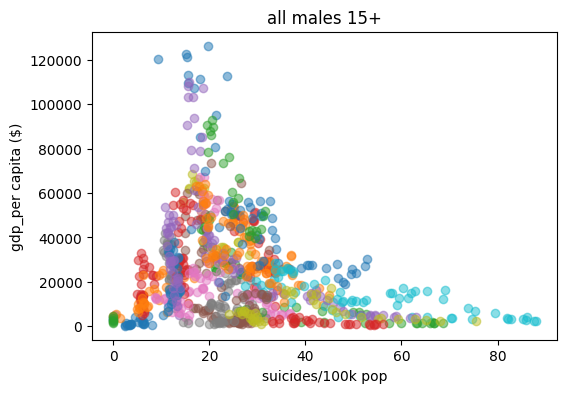

In [6]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("all males 15+")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 5.800, r: 0.04, Wskaźnik: 0.310


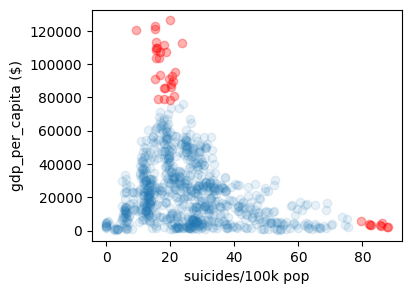

In [7]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

## females

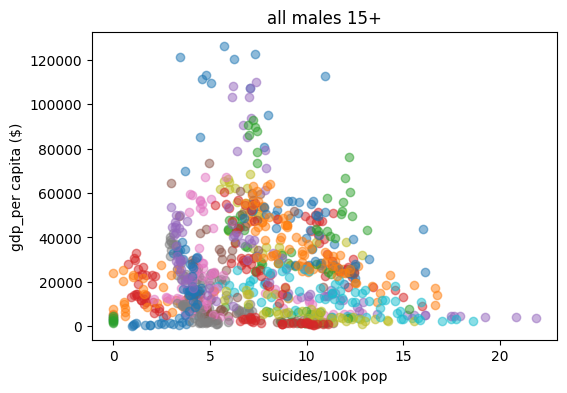

In [8]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("all males 15+")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 6.800, r: 0.03, Wskaźnik: 0.286


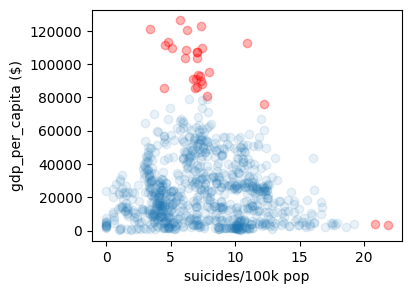

In [9]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

\newpage

# 15-24 years old

\newpage

In [10]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data[data["age"] == "15-24 years"].reset_index(drop=True)

## males

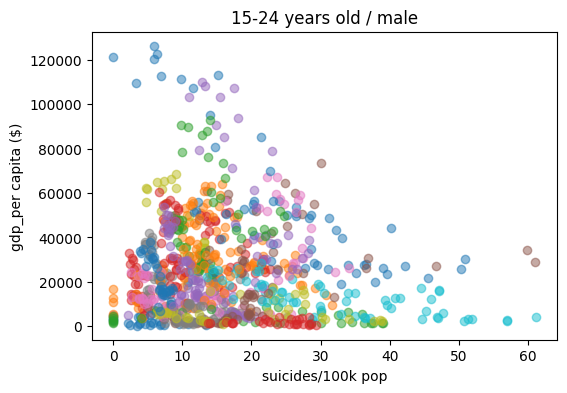

In [11]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("15-24 years old / male")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 6.400, r: 0.04, Wskaźnik: 0.299


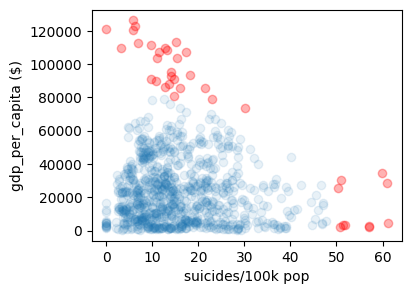

In [12]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

\newpage

## females

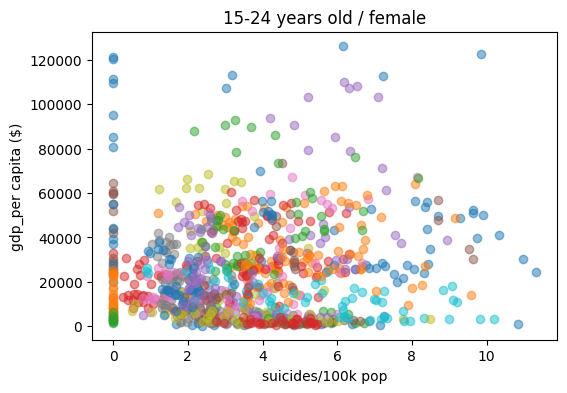

In [13]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("15-24 years old / female")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 7.900, r: 0.02, Wskaźnik: 0.259


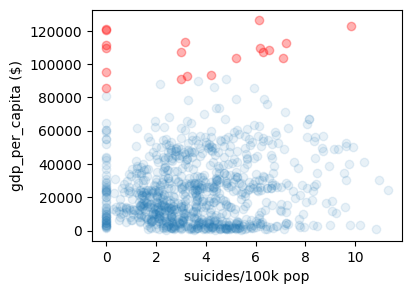

In [14]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

\newpage

# 25-34 years old

\newpage

In [15]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data[data["age"] == "25-34 years"].reset_index(drop=True)

## males

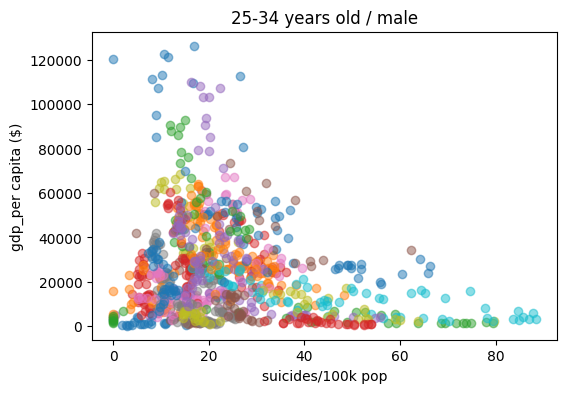

In [16]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("25-34 years old / male")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 5.500, r: 0.06, Wskaźnik: 0.317


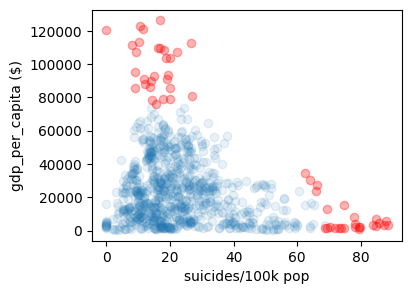

In [17]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

## females

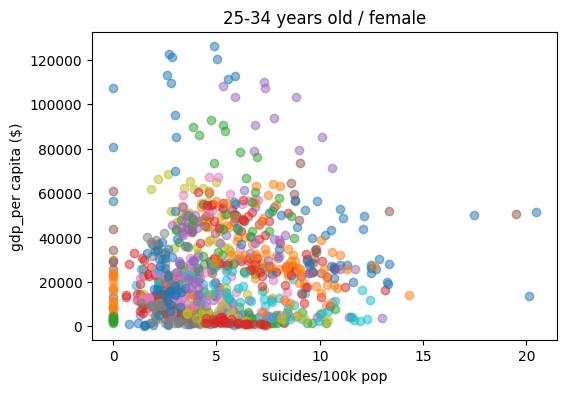

In [18]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("25-34 years old / female")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 6.300, r: 0.03, Wskaźnik: 0.209


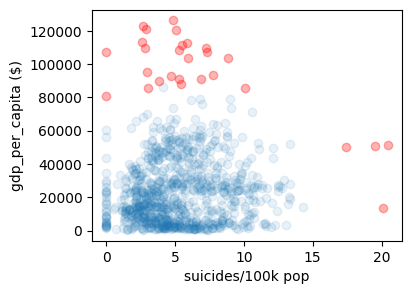

In [19]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

# 35-54 years old

\newpage

In [20]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data[data["age"] == "35-54 years"].reset_index(drop=True)

## males

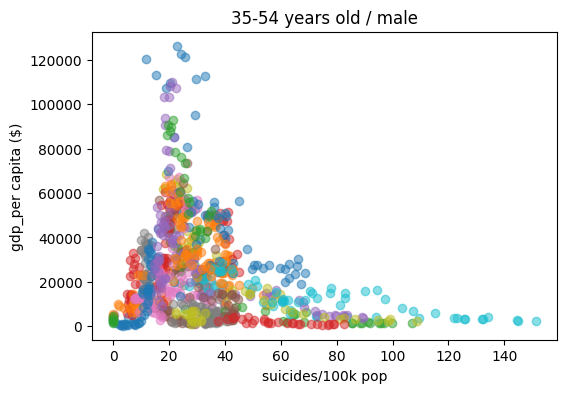

In [21]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("35-54 years old / male")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 6.900, r: 0.04, Wskaźnik: 0.306


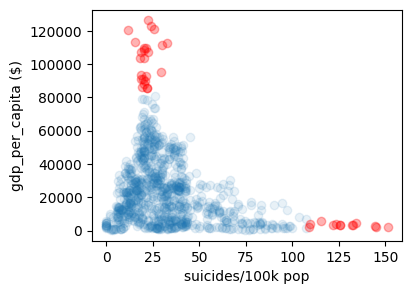

In [22]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

## females

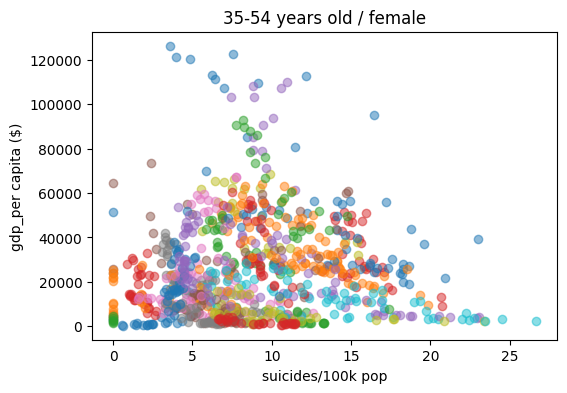

In [23]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("35-54 years old / female")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 7.200, r: 0.03, Wskaźnik: 0.266


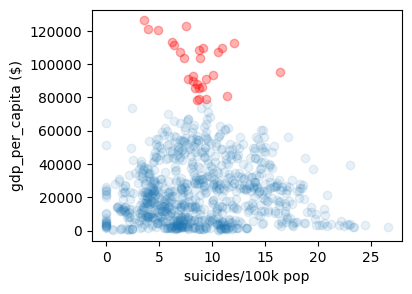

In [24]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

# 55-74 years old

\newpage

In [25]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data[data["age"] == "55-74 years"].reset_index(drop=True)

## males

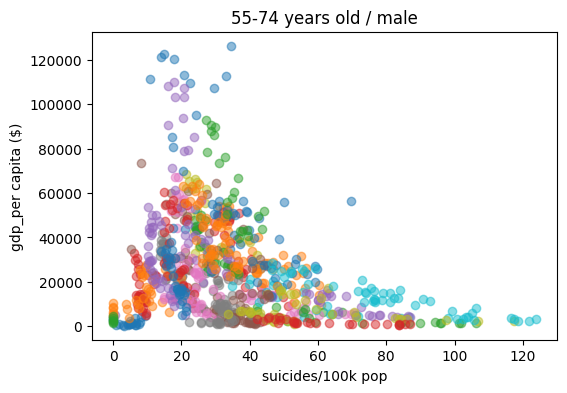

In [26]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("55-74 years old / male")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 3.800, r: 0.04, Wskaźnik: 0.294


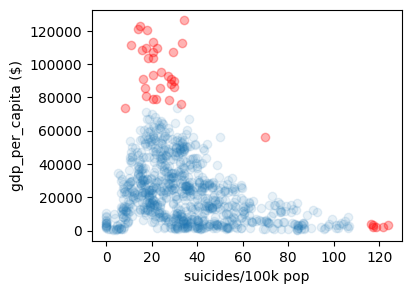

In [27]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

## females

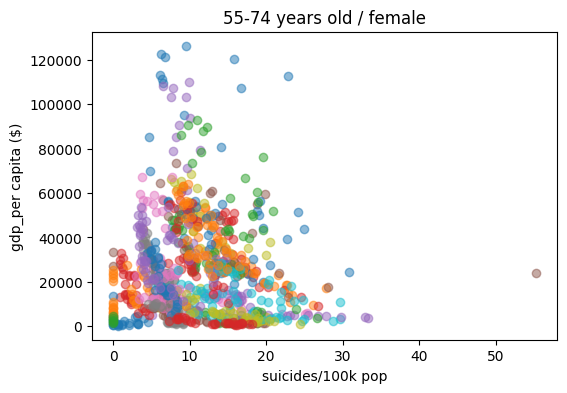

In [28]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("55-74 years old / female")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 7.000, r: 0.03, Wskaźnik: 0.266


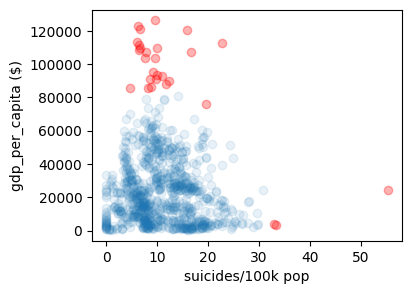

In [29]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

# 75+ years old

\newpage

In [30]:
data = data0[data0["country"].isin(Europe)].reset_index(drop=True)

data = data[data["age"] == "75+ years"].reset_index(drop=True)

## males

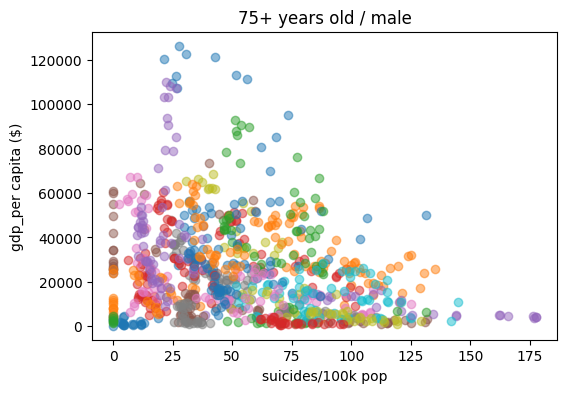

In [31]:
data_male = data[data["sex"] == "male"].reset_index(drop=True)
data_male["idx"] = data_male.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("75+ years old / male")

for i in data_male["idx"].unique():
    plt.scatter(data_male.loc[data_male["idx"]==i, "suicides/100k pop"], data_male.loc[data_male["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 4.200, r: 0.04, Wskaźnik: 0.261


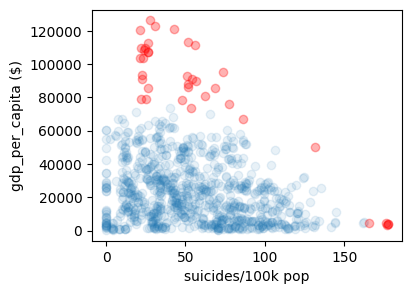

In [32]:
x_train = data_male[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()

## females

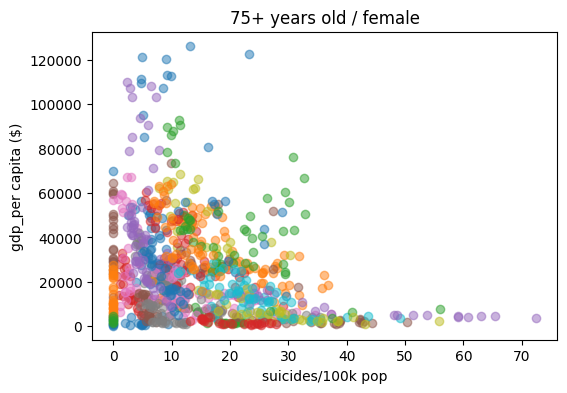

In [33]:
data_female = data[data["sex"] == "female"].reset_index(drop=True)
data_female["idx"] = data_female.groupby("country").ngroup()

# Plot
plt.figure(figsize=(6, 4))
plt.title("75+ years old / female")

for i in data_female["idx"].unique():
    plt.scatter(data_female.loc[data_female["idx"]==i, "suicides/100k pop"], data_female.loc[data_female["idx"]==i, "gdp_per_capita ($)"], alpha=0.5)

plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per capita ($)")
plt.show()

Licznosc zbioru: 901
Najlepszy mnożnik h: 4.800, r: 0.05, Wskaźnik: 0.258


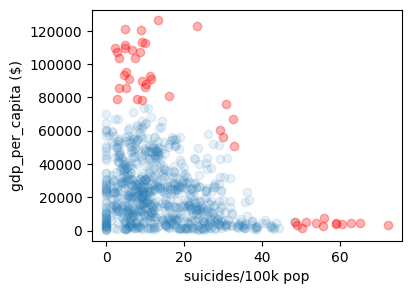

In [34]:
x_train = data_female[["suicides/100k pop", "gdp_per_capita ($)"]].dropna().to_numpy()
print(f"Licznosc zbioru: {x_train.shape[0]}")

#
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.1, 10.1, 0.1):
# for h_mul in np.array([0.9, 1.0, 1.1]):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.51, 0.01):
#     for r in np.array([0.01, 0.05, 0.1]):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("suicides/100k pop")
plt.ylabel("gdp_per_capita ($)")
plt.show()